# Introduction 

In this notebook, we will implement [*Latent Credible Analysis*](https://research.fb.com/publications/latent-credibility-analysis/) models. These are latent probablistic models that use hidden (latent) variables to represents the unknown data source reliabilities and underlying truth values. 

We implement only simpleLCA for now as extension to other models are relatively straight forward.



# SimpleLCA

Here is the plate model of simpleLCA. 

![simpleLCA](./gfx/simpleLCA.png)

### Data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os.path as op
import numpy as np
import seaborn as sns
import pyro

import sys
sys.path.insert(0, '../')

from spectrum.preprocessing import encoders
from spectrum.judge import lca, utils
from spectrum import evaluator

In [3]:
DATA_DIR = '../data'
DATA_SET = 'population'

In [4]:
truths = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'truths.csv'))
claims = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'claims.csv'))

In [5]:
truths.shape, claims.shape

((293, 3), (1035, 5))

We decide to model city population as discrete value. Moreover we consider the hidden truth value is only from the set of available assertions. Thus we need to label encode `value` of claims data frame.

### Data Preprocessing 

We need to label encode values of objects in order to feed them to our simpleLCA model

In [6]:
claims_enc, le_dict = encoders.transform(claims)

build the confidence matrix, $[w_{s,o}]$ in the paper, if $w_{s,o} = 1$, then the source s does make an assertion about object o.

In [7]:
mask = lca.build_mask(claims_enc)

we also need to build an observation dictionary.

In [8]:
observation = lca.build_observation(claims_enc)

### Model

Create some data

# Inference 

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [10]:
losses = lca.bvi(lca.lca_model, lca.lca_guide, observation, mask)

current loss - 3039.902975788131
current loss - 3166.596877663387
current loss - 3028.9692513801165
current loss - 3055.0229494142186
current loss - 3026.5907913344327
current loss - 3128.1995954519552
current loss - 3422.933020585906
current loss - 2955.357322175656
current loss - 3146.305183285838
current loss - 3068.8883679461087


/Users/totucuong/miniconda3/envs/spectrum/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


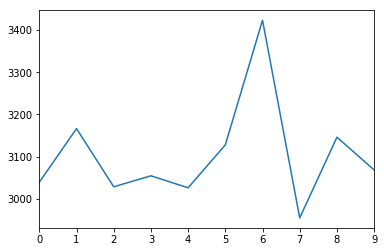

In [11]:
sns.tsplot(losses)

We can see that BVI does not do so well given Trace_ELBO loss. I think Trace_ELBO is not suitable for discrete distributions.

# Evaluation 

In [12]:
discovered_truths = lca.discover_truths(posteriors=pyro.get_param_store())

We need to inverse transform the discovered truth value of each object into their original space.

In [13]:
discovered_truths['value'] = discovered_truths.apply(lambda x: le_dict[x['object_id']].inverse_transform([x['value']])[0], axis=1)

In [14]:
evaluator.accuracy(truths, discovered_truths)

0.46757679180887374

The result is bad. This is expected if we look at the plot of loss values during training. They did not converge! The following can be reasons:
    1. Since SVI estimate gradients at each training step by performing sampling of `guide()`. The default number of is 1. We may increase the estimation accuracy by increasing the number of training.
    2. Our `guide()` model is just not good enough or `model()

# Appendix